In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import quad
import emcee
import corner
import pandas as pd
from numba import njit

# --- FIXED COSMOLOGICAL PARAMETERS (for r_d calculation) ---
# These values are fixed for r_d, which depends on early-universe physics,
# not typically sampled in late-time DESI/SN analyses.
OMEGA_B_FIXED = 0.048 # A typical Planck/BBN value for Omega_b from previous 3D run's best-fit
OMEGA_K_FIXED = 0.0   # Flat universe assumed (can be changed if Omega_k is sampled)
Neff_fixed = 3.044 # Standard effective number of relativistic species
# --- Constants ---
c = 299792.458 # km/s (speed of light)

In [2]:
import numpy as np
import pandas as pd

# -----------------------------
# Load Pantheon+ Data
# -----------------------------
# Ensure these files are in your project directory:
# Pantheon+SH0ES.dat
# Pantheon+SH0ES_STAT+SYS.cov
df = pd.read_csv("Pantheon+SH0ES.dat", sep=r'\s+', comment='#') 
original_full_df_indices = df[df['USED_IN_SH0ES_HF'] == 1].index.values
df_filtered = df[df['USED_IN_SH0ES_HF'] == 1].reset_index(drop=True)

# These variables will be used globally by likelihood functions
z = df_filtered['zHD'].values
mu_obs = df_filtered['MU_SH0ES'].values

with open("Pantheon+SH0ES_STAT+SYS.cov") as f:
    N = int(f.readline())  
    flat_cov = np.loadtxt(f)
    cov_all = flat_cov.reshape((N, N))
cov = cov_all[np.ix_(original_full_df_indices, original_full_df_indices)]
jitter = 1e-9 * np.eye(cov.shape[0])
inv_cov = np.linalg.inv(cov + jitter)
print("✅ Pantheon+ Data Loaded.")

✅ Pantheon+ Data Loaded.


In [3]:
import numpy as np
from scipy.integrate import quad
from numba import njit 

# --- Define the Dark Energy Evolution Factor g(z) for CPL parametrization ---
@njit 
def g_z_CPL(z_val, w0, wa):
    a = 1.0 / (1.0 + z_val)
    if a <= 0:
        return 0.0 
    return a**(-3.0 * (1.0 + w0 + wa)) * np.exp(-3.0 * wa * (1.0 - a))

# --- Hubble Parameter H(z) for General Model (w0waCDM + Omega_k) ---
@njit 
def H_z_general(z_val, H0, Omega_m, w0, wa, Omega_k):
    Omega_de0 = 1 - Omega_m - Omega_k
    
    if Omega_de0 < 0 or Omega_m < 0: 
        return np.inf 

    term_in_sqrt = Omega_m * (1.0 + z_val)**3 + Omega_k * (1.0 + z_val)**2 + Omega_de0 * g_z_CPL(z_val, w0, wa)
    
    if term_in_sqrt <= 0:
        return np.inf
        
    return H0 * np.sqrt(term_in_sqrt)

# --- Integrand for D_M_general ---
@njit 
def E_inv_for_DM_general_integrand_numba(z_prime, H0, Omega_m, w0, wa, Omega_k):
    Hz_prime = H_z_general(z_prime, H0, Omega_m, w0, wa, Omega_k)
    if not np.isfinite(Hz_prime) or Hz_prime == 0:
        return np.nan 
    return H0 / Hz_prime

# --- D_M_general --- (NOT @njit)
def D_M_general(z_val, H0, Omega_m, w0, wa, Omega_k):
    if isinstance(z_val, np.ndarray):
        integral_results = np.array([quad(E_inv_for_DM_general_integrand_numba, 0, zi, args=(H0, Omega_m, w0, wa, Omega_k))[0] for zi in z_val])
    else: 
        integral_results = quad(E_inv_for_DM_general_integrand_numba, 0, z_val, args=(H0, Omega_m, w0, wa, Omega_k))[0]
    
    if not np.all(np.isfinite(integral_results)):
        return -np.inf 
        
    return (c / H0) * integral_results

# --- D_H_general --- (IS @njit)
@njit 
def D_H_general(z_val, H0, Omega_m, w0, wa, Omega_k):
    Hz_val = H_z_general(z_val, H0, Omega_m, w0, wa, Omega_k)
    if not np.isfinite(Hz_val) or Hz_val == 0:
        return np.inf 
    return c / Hz_val

# --- D_V_general --- (NOT @njit)
def D_V_general(z_val, H0, Omega_m, w0, wa, Omega_k):
    dm_val = D_M_general(z_val, H0, Omega_m, w0, wa, Omega_k) 
    dh_val = D_H_general(z_val, H0, Omega_m, w0, wa, Omega_k)
    
    if not np.all(np.isfinite(dm_val)) or not np.all(np.isfinite(dh_val)):
        return np.inf

    inner_val = z_val * dm_val**2 * dh_val
    if inner_val < 0:
        return np.inf 
        
    return inner_val**(1/3.0)

# --- Theoretical Sound Horizon (r_d) ---
@njit 
def r_d_th(H0, Omega_m, Omega_b):
    h = H0 / 100.0
    ombh2_calc = Omega_b * h**2 
    omch2_calc = Omega_m * h**2 - ombh2_calc 

    if not (ombh2_calc > 0.005 and omch2_calc > 0): 
        return np.inf 
        
    omegamh2_calc = Omega_m * h**2 
    if not (omegamh2_calc > 0):
        return np.inf

    rd = 147.05 * (ombh2_calc / 0.02236)**(-0.13) * \
         (omegamh2_calc / 0.1432)**(-0.23) * \
         (Neff_fixed / 3.04)**(-0.1) 
    return rd

In [4]:
import numpy as np

# --- General distance_modulus (for SNe and BAO) --- (NOT @njit)
# This version is flexible enough to take all parameters, but the model will
# ignore parameters not relevant to its specifics (e.g., Omega_k is fixed for Flat LCDM)
def distance_modulus_general(z_val, H0, Omega_m, w0, wa, Omega_k):
    # This function depends on D_M_general, which takes all parameters.
    dL = (1.0 + z_val) * D_M_general(z_val, H0, Omega_m, w0, wa, Omega_k)
    if not np.all(np.isfinite(dL)): 
        return np.inf
    return 5 * np.log10(dL + 1e-10) + 25

# --- Log-likelihood function for Pantheon+ (General Model) --- (NOT @njit)
# This single function can serve as the core for all Pantheon+ models.
def log_likelihood_pantheon_general(theta, z_data, mu_obs_data, inv_cov_data,
                                    sampled_params_names): 

    # Extract parameters based on the specific model's 'theta' structure
    params_dict = {}
    for i, p_name in enumerate(sampled_params_names):
        params_dict[p_name] = theta[i]

    # Assign default values for parameters not sampled in this model
    H0 = params_dict.get('H0')
    Omega_m = params_dict.get('Omega_m')
    Omega_k = params_dict.get('Omega_k', OMEGA_K_FIXED) # Use fixed if not sampled
    w0 = params_dict.get('w0', -1.0) # Default to -1 (LambdaCDM) if not sampled
    wa = params_dict.get('wa', 0.0)  # Default to 0 (LambdaCDM) if not sampled

    # --- Apply Priors (specific to each parameter) ---
    if not (55 < H0 < 90 and 0.01 < Omega_m < 0.8):
        return -np.inf 
    if 'Omega_k' in sampled_params_names and not (-0.3 < Omega_k < 0.3): 
        return -np.inf
    if 'w0' in sampled_params_names and not (-3 < w0 < 1): 
        return -np.inf
    if 'wa' in sampled_params_names and not (-3 < wa < 2): 
        return -np.inf
    
    # Enforce w0 + wa < 0 for dynamical dark energy models, if w0 or wa are sampled
    if ('w0' in sampled_params_names or 'wa' in sampled_params_names) and w0 + wa >= 0:
        return -np.inf

    # Calculate theoretical distance modulus
    mu_th = distance_modulus_general(z_data, H0, Omega_m, w0, wa, Omega_k)
    
    if not np.all(np.isfinite(mu_th)):
        return -np.inf
    
    delta = mu_obs_data - mu_th
    chi2 = delta @ inv_cov_data @ delta 
    
    return -0.5 * chi2

# --- Log-likelihood function for DESI BAO (General Model) --- (NOT @njit)
# This single function can serve as the core for all DESI BAO models.
# (This code block remains unchanged from previous versions, included for completeness of Cell 4)
def log_likelihood_desi_general(theta, z_eff_desi_data, observed_values_desi_data, quantity_types_desi_data, inv_cov_desi_data,
                                sampled_params_names): 

    params_dict = {}
    for i, p_name in enumerate(sampled_params_names):
        params_dict[p_name] = theta[i]

    H0 = params_dict.get('H0')
    Omega_m = params_dict.get('Omega_m')
    Omega_k = params_dict.get('Omega_k', OMEGA_K_FIXED) 
    w0 = params_dict.get('w0', -1.0) 
    wa = params_dict.get('wa', 0.0) 

    # --- Apply Priors (specific to each parameter) ---
    if not (55 < H0 < 90 and 0.01 < Omega_m < 0.8):
        return -np.inf 
    if 'Omega_k' in sampled_params_names and not (-0.3 < Omega_k < 0.3): 
        return -np.inf
    if 'w0' in sampled_params_names and not (-3 < w0 < 1): 
        return -np.inf
    if 'wa' in sampled_params_names and not (-3 < wa < 2): 
        return -np.inf
    
    if ('w0' in sampled_params_names or 'wa' in sampled_params_names) and w0 + wa >= 0:
        return -np.inf

    # --- Calculate r_d ---
    rd_model = r_d_th(H0, Omega_m, OMEGA_B_FIXED) 
    if not np.isfinite(rd_model): 
        return -np.inf

    # --- Calculate Predicted BAO Values ---
    predicted_values_list = []
    for i, quantity_type in enumerate(quantity_types_desi_data): 
        z_val = z_eff_desi_data[i] 
        
        val = np.nan 
        if quantity_type == 'DV_over_rs':
            val = D_V_general(z_val, H0, Omega_m, w0, wa, Omega_k) / rd_model
        elif quantity_type == 'DM_over_rs':
            val = D_M_general(z_val, H0, Omega_m, w0, wa, Omega_k) / rd_model
        elif quantity_type == 'DH_over_rs':
            val = D_H_general(z_val, H0, Omega_m, w0, wa, Omega_k) / rd_model
        
        if not np.isfinite(val):
            return -np.inf
            
        predicted_values_list.append(val)
        
    predicted_values_desi = np.array(predicted_values_list)
    
    # --- Calculate Chi-squared ---
    delta_desi = observed_values_desi_data - predicted_values_desi
    chi2_desi = delta_desi @ inv_cov_desi_data @ delta_desi
    
    return -0.5 * chi2_desi

Created output directory: results_many_models_supernova/
🔁 Running MCMC for Pantheon+ (Flat LambdaCDM)...


100%|██████████| 15000/15000 [20:26<00:00, 12.23it/s]


✅ MCMC for Pantheon+ (Flat LambdaCDM) completed!
Shape of processed Pantheon+ (Flat LambdaCDM) samples: (38400, 2)


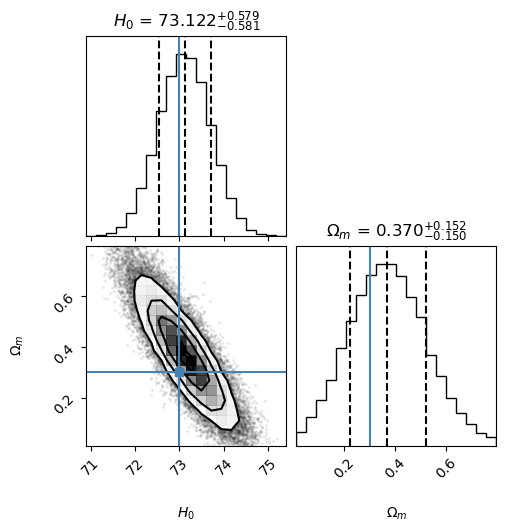

📊 $H_0$ = 73.1217 +0.5786 -0.5814
📊 $\Omega_m$ = 0.3697 +0.1524 -0.1497

Average acceptance fraction: 0.72


In [5]:
import numpy as np
import matplotlib.pyplot as plt
import emcee
import corner
import os 

# --- Create output directory for plots ---
output_dir = "results_many_models_supernova" # New folder name
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
    print(f"Created output directory: {output_dir}/")

# --- MCMC setup for Pantheon+ (Flat LambdaCDM) ---
# Parameters: H0, Omega_m
ndim_pantheon_flat_lcdm = 2          
nwalkers_pantheon_flat_lcdm = 32     
nsteps_pantheon_flat_lcdm = 15000    
burn_in_pantheon_flat_lcdm = 3000    
thin_factor_pantheon_flat_lcdm = 10

# Initial guess (closer to Pantheon+'s preference for LambdaCDM)
initial_guess_pantheon_flat_lcdm = np.array([73.0, 0.30]) 
pos_pantheon_flat_lcdm = initial_guess_pantheon_flat_lcdm + 1e-3 * np.random.randn(nwalkers_pantheon_flat_lcdm, ndim_pantheon_flat_lcdm)

# Data arguments for Pantheon+ likelihood
data_args_pantheon = (z, mu_obs, inv_cov)

# List of parameter names for the likelihood to know what's sampled
# w0=-1, wa=0, Omega_k=0 are defaults in log_likelihood_pantheon_general
sampled_params_names_pantheon_flat_lcdm = ['H0', 'Omega_m']

# Create a lambda function to pass correct args to log_likelihood_pantheon_general
log_prob_fn_pantheon_flat_lcdm = lambda theta, data_args: log_likelihood_pantheon_general(theta, *data_args, sampled_params_names_pantheon_flat_lcdm)

sampler_pantheon_flat_lcdm = emcee.EnsembleSampler(nwalkers_pantheon_flat_lcdm, ndim_pantheon_flat_lcdm, 
                                          log_prob_fn_pantheon_flat_lcdm, 
                                          args=(data_args_pantheon,))

print("🔁 Running MCMC for Pantheon+ (Flat LambdaCDM)...")
sampler_pantheon_flat_lcdm.run_mcmc(pos_pantheon_flat_lcdm, nsteps_pantheon_flat_lcdm, progress=True)
print("✅ MCMC for Pantheon+ (Flat LambdaCDM) completed!")

# --- PROCESS and PLOT POSTERIOR ---
samples_pantheon_flat_lcdm = sampler_pantheon_flat_lcdm.get_chain(discard=burn_in_pantheon_flat_lcdm, thin=thin_factor_pantheon_flat_lcdm, flat=True)

# Store results for summary table (initialize if first run, otherwise append)
if 'results_table_pantheon' not in globals(): # Use a new table for Pantheon+ results
    results_table_pantheon = []
current_model_results_pantheon = {'Model': 'Pantheon+ (Flat LambdaCDM)'}
plot_labels = [r"$H_0$", r"$\Omega_m$"]

print(f"Shape of processed Pantheon+ (Flat LambdaCDM) samples: {samples_pantheon_flat_lcdm.shape}")
fig_pantheon_flat_lcdm = corner.corner(samples_pantheon_flat_lcdm, labels=plot_labels,
                               truths=initial_guess_pantheon_flat_lcdm, 
                               show_titles=True, title_fmt=".3f", quantiles=[0.16, 0.5, 0.84])
plt.savefig(os.path.join(output_dir, "pantheon_flat_lcdm_corner.png"), dpi=300, format='png') 
plt.show()

# Extract and print best-fit values
for i, p_label in enumerate(plot_labels):
    p_mcmc = np.percentile(samples_pantheon_flat_lcdm[:, i], [16, 50, 84])
    mean = p_mcmc[1]
    plus_err = p_mcmc[2] - mean
    minus_err = mean - p_mcmc[0]
    print(f"📊 {p_label} = {mean:.4f} +{plus_err:.4f} -{minus_err:.4f}")
    current_model_results_pantheon[p_label] = f"{mean:.4f} (+{plus_err:.4f} -{minus_err:.4f})"

results_table_pantheon.append(current_model_results_pantheon)

print(f"\nAverage acceptance fraction: {np.mean(sampler_pantheon_flat_lcdm.acceptance_fraction):.2f}")

🔁 Running MCMC for Pantheon+ (LambdaCDM+Omega_k)...


  0%|          | 72/20000 [00:11<49:04,  6.77it/s]  C:\Users\GuilhermedeSouzaFern\AppData\Local\Temp\ipykernel_12508\3120394376.py:39: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  integral_results = np.array([quad(E_inv_for_DM_general_integrand_numba, 0, zi, args=(H0, Omega_m, w0, wa, Omega_k))[0] for zi in z_val])
100%|██████████| 20000/20000 [48:35<00:00,  6.86it/s]


✅ MCMC for Pantheon+ (LambdaCDM+Omega_k) completed!
Shape of processed Pantheon+ (LambdaCDM+Omega_k) samples: (102400, 3)


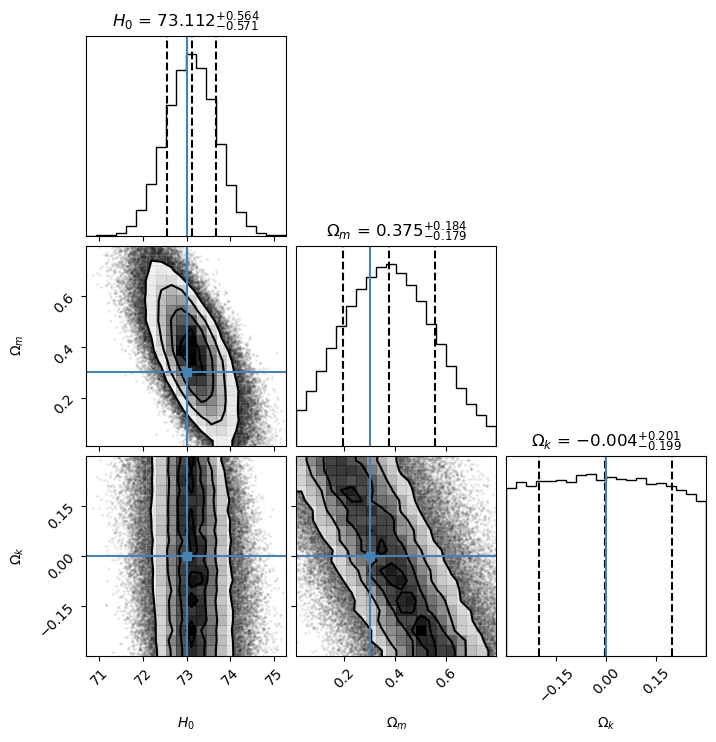

📊 $H_0$ = 73.1119 +0.5639 -0.5707
📊 $\Omega_m$ = 0.3749 +0.1839 -0.1795
📊 $\Omega_k$ = -0.0038 +0.2013 -0.1990

Average acceptance fraction: 0.59


In [6]:
import numpy as np
import matplotlib.pyplot as plt
import emcee
import corner

# --- MCMC setup for Pantheon+ (LambdaCDM+Omega_k) ---
# Parameters: H0, Omega_m, Omega_k
ndim_pantheon_lcdm_omk = 3          
nwalkers_pantheon_lcdm_omk = 64     
nsteps_pantheon_lcdm_omk = 20000    
burn_in_pantheon_lcdm_omk = 4000    
thin_factor_pantheon_lcdm_omk = 10

# Initial guess (start at flat, Omega_k=0)
initial_guess_pantheon_lcdm_omk = np.array([73.0, 0.30, 0.0]) 
pos_pantheon_lcdm_omk = initial_guess_pantheon_lcdm_omk + 1e-3 * np.random.randn(nwalkers_pantheon_lcdm_omk, ndim_pantheon_lcdm_omk)

# Data arguments for Pantheon+ likelihood (already defined)
# sampled_params_names: H0, Omega_m, Omega_k (w0=-1, wa=0 are defaults)
sampled_params_names_pantheon_lcdm_omk = ['H0', 'Omega_m', 'Omega_k']
log_prob_fn_pantheon_lcdm_omk = lambda theta, data_args: log_likelihood_pantheon_general(theta, *data_args, sampled_params_names_pantheon_lcdm_omk)

sampler_pantheon_lcdm_omk = emcee.EnsembleSampler(nwalkers_pantheon_lcdm_omk, ndim_pantheon_lcdm_omk, 
                                          log_prob_fn_pantheon_lcdm_omk, 
                                          args=(data_args_pantheon,))

print("🔁 Running MCMC for Pantheon+ (LambdaCDM+Omega_k)...")
sampler_pantheon_lcdm_omk.run_mcmc(pos_pantheon_lcdm_omk, nsteps_pantheon_lcdm_omk, progress=True)
print("✅ MCMC for Pantheon+ (LambdaCDM+Omega_k) completed!")

# --- PROCESS and PLOT POSTERIOR ---
samples_pantheon_lcdm_omk = sampler_pantheon_lcdm_omk.get_chain(discard=burn_in_pantheon_lcdm_omk, thin=thin_factor_pantheon_lcdm_omk, flat=True)

current_model_results_pantheon = {'Model': 'Pantheon+ (LambdaCDM+Omega_k)'}
plot_labels = [r"$H_0$", r"$\Omega_m$", r"$\Omega_k$"]

print(f"Shape of processed Pantheon+ (LambdaCDM+Omega_k) samples: {samples_pantheon_lcdm_omk.shape}")
fig_pantheon_lcdm_omk = corner.corner(samples_pantheon_lcdm_omk, labels=plot_labels,
                               truths=initial_guess_pantheon_lcdm_omk, 
                               show_titles=True, title_fmt=".3f", quantiles=[0.16, 0.5, 0.84])
plt.savefig(os.path.join(output_dir, "pantheon_lcdm_omk_corner.png"), dpi=300, format='png') 
plt.show()

for i, p_label in enumerate(plot_labels):
    p_mcmc = np.percentile(samples_pantheon_lcdm_omk[:, i], [16, 50, 84])
    mean = p_mcmc[1]
    plus_err = p_mcmc[2] - mean
    minus_err = mean - p_mcmc[0]
    print(f"📊 {p_label} = {mean:.4f} +{plus_err:.4f} -{minus_err:.4f}")
    current_model_results_pantheon[p_label] = f"{mean:.4f} (+{plus_err:.4f} -{minus_err:.4f})"

results_table_pantheon.append(current_model_results_pantheon)

print(f"\nAverage acceptance fraction: {np.mean(sampler_pantheon_lcdm_omk.acceptance_fraction):.2f}")

🔁 Running MCMC for Pantheon+ (wCDM)...


100%|██████████| 20000/20000 [54:19<00:00,  6.14it/s] 


✅ MCMC for Pantheon+ (wCDM) completed!
Shape of processed Pantheon+ (wCDM) samples: (102400, 3)


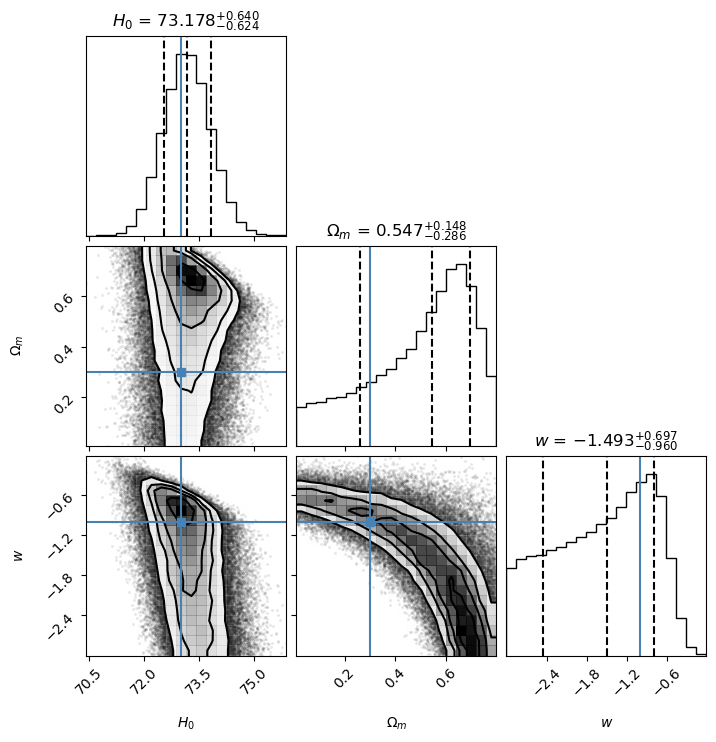

📊 $H_0$ = 73.1775 +0.6397 -0.6245
📊 $\Omega_m$ = 0.5468 +0.1477 -0.2861
📊 $w$ = -1.4930 +0.6969 -0.9602

Average acceptance fraction: 0.53


In [7]:
import numpy as np
import matplotlib.pyplot as plt
import emcee
import corner

# --- MCMC setup for Pantheon+ (wCDM) ---
# Parameters: H0, Omega_m, w
ndim_pantheon_wcdm = 3          
nwalkers_pantheon_wcdm = 64     
nsteps_pantheon_wcdm = 20000    
burn_in_pantheon_wcdm = 4000    
thin_factor_pantheon_wcdm = 10

# Initial guess (start from LambdaCDM, w=-1)
initial_guess_pantheon_wcdm = np.array([73.0, 0.30, -1.0]) 
pos_pantheon_wcdm = initial_guess_pantheon_wcdm + 1e-3 * np.random.randn(nwalkers_pantheon_wcdm, ndim_pantheon_wcdm)

# Data arguments for Pantheon+ likelihood (already defined)
# sampled_params_names: H0, Omega_m, w0 (w), wa=0, Omega_k=0
sampled_params_names_pantheon_wcdm = ['H0', 'Omega_m', 'w0'] 
log_prob_fn_pantheon_wcdm = lambda theta, data_args: log_likelihood_pantheon_general(theta, *data_args, sampled_params_names_pantheon_wcdm)

sampler_pantheon_wcdm = emcee.EnsembleSampler(nwalkers_pantheon_wcdm, ndim_pantheon_wcdm, 
                                          log_prob_fn_pantheon_wcdm, 
                                          args=(data_args_pantheon,))

print("🔁 Running MCMC for Pantheon+ (wCDM)...")
sampler_pantheon_wcdm.run_mcmc(pos_pantheon_wcdm, nsteps_pantheon_wcdm, progress=True)
print("✅ MCMC for Pantheon+ (wCDM) completed!")

# --- PROCESS and PLOT POSTERIOR ---
samples_pantheon_wcdm = sampler_pantheon_wcdm.get_chain(discard=burn_in_pantheon_wcdm, thin=thin_factor_pantheon_wcdm, flat=True)

current_model_results_pantheon = {'Model': 'Pantheon+ (wCDM)'}
plot_labels = [r"$H_0$", r"$\Omega_m$", r"$w$"]

print(f"Shape of processed Pantheon+ (wCDM) samples: {samples_pantheon_wcdm.shape}")
fig_pantheon_wcdm = corner.corner(samples_pantheon_wcdm, labels=plot_labels,
                           truths=initial_guess_pantheon_wcdm, 
                           show_titles=True, title_fmt=".3f", quantiles=[0.16, 0.5, 0.84])
plt.savefig(os.path.join(output_dir, "pantheon_wcdm_corner.png"), dpi=300, format='png') 
plt.show()

for i, p_label in enumerate(plot_labels):
    p_mcmc = np.percentile(samples_pantheon_wcdm[:, i], [16, 50, 84])
    mean = p_mcmc[1]
    plus_err = p_mcmc[2] - mean
    minus_err = mean - p_mcmc[0]
    print(f"📊 {p_label} = {mean:.4f} +{plus_err:.4f} -{minus_err:.4f}")
    current_model_results_pantheon[p_label] = f"{mean:.4f} (+{plus_err:.4f} -{minus_err:.4f})"

results_table_pantheon.append(current_model_results_pantheon)

print(f"\nAverage acceptance fraction: {np.mean(sampler_pantheon_wcdm.acceptance_fraction):.2f}")

🔁 Running MCMC for Pantheon+ (w0waCDM)...


100%|██████████| 15000/15000 [41:21<00:00,  6.05it/s]


✅ MCMC for Pantheon+ (w0waCDM) completed!
Shape of processed Pantheon+ (w0waCDM) samples: (76800, 4)


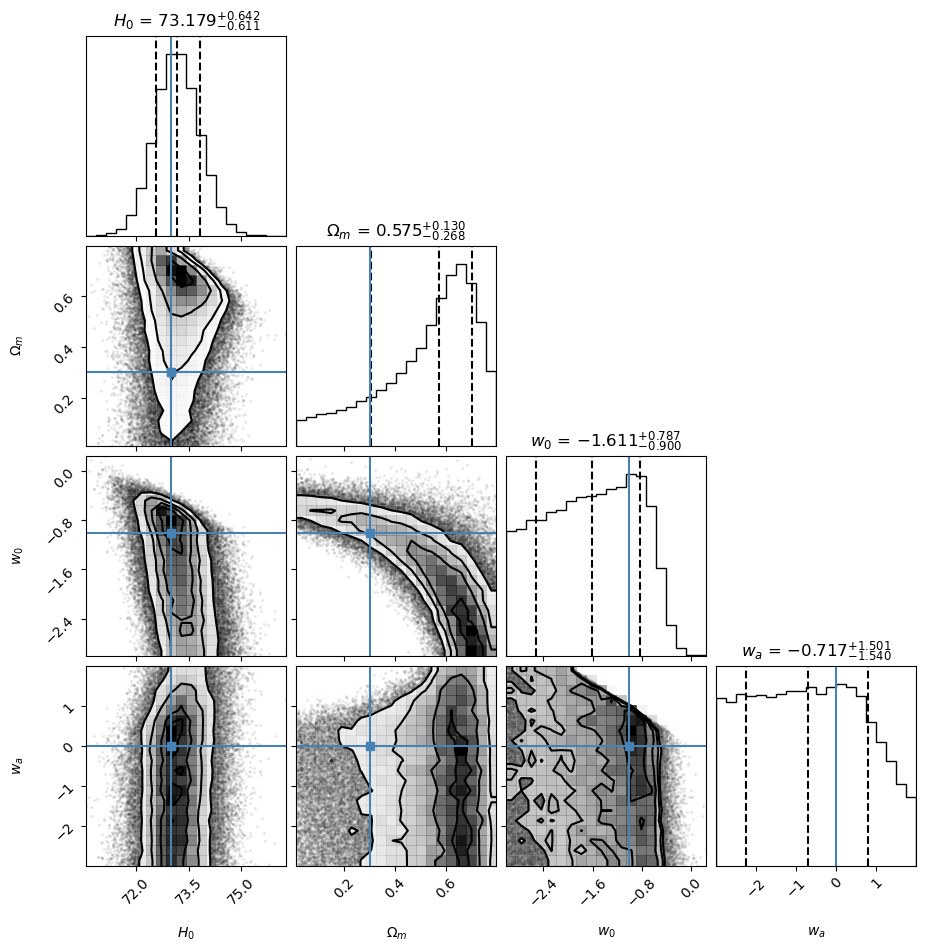

📊 $H_0$ = 73.1786 +0.6416 -0.6114
📊 $\Omega_m$ = 0.5746 +0.1296 -0.2679
📊 $w_0$ = -1.6113 +0.7867 -0.9002
📊 $w_a$ = -0.7167 +1.5010 -1.5403

Average acceptance fraction: 0.44


In [8]:
import numpy as np
import matplotlib.pyplot as plt
import emcee
import corner

# --- MCMC setup for Pantheon+ (w0waCDM) ---
# Parameters: H0, Omega_m, w0, wa
ndim_pantheon_w0wa = 4 
nwalkers_pantheon_w0wa = 64 
nsteps_pantheon_w0wa = 15000 
burn_in_pantheon_w0wa = 3000 
thin_factor_pantheon_w0wa = 10

# Initial guess (start from LambdaCDM, w0=-1, wa=0)
initial_guess_pantheon_w0wa = np.array([73.0, 0.30, -1.0, 0.0]) 
pos_pantheon_w0wa = initial_guess_pantheon_w0wa + 1e-3 * np.random.randn(nwalkers_pantheon_w0wa, ndim_pantheon_w0wa) 

# Data arguments for Pantheon+ likelihood (already defined)
# sampled_params_names: H0, Omega_m, w0, wa
sampled_params_names_pantheon_w0wa = ['H0', 'Omega_m', 'w0', 'wa']
log_prob_fn_pantheon_w0wa = lambda theta, data_args: log_likelihood_pantheon_general(theta, *data_args, sampled_params_names_pantheon_w0wa)


sampler_pantheon_w0wa = emcee.EnsembleSampler(nwalkers_pantheon_w0wa, ndim_pantheon_w0wa, 
                                          log_prob_fn_pantheon_w0wa, 
                                          args=(data_args_pantheon,))

print("🔁 Running MCMC for Pantheon+ (w0waCDM)...")
sampler_pantheon_w0wa.run_mcmc(pos_pantheon_w0wa, nsteps_pantheon_w0wa, progress=True)
print("✅ MCMC for Pantheon+ (w0waCDM) completed!")

# --- PROCESS and PLOT POSTERIOR ---
samples_pantheon_w0wa = sampler_pantheon_w0wa.get_chain(discard=burn_in_pantheon_w0wa, thin=thin_factor_pantheon_w0wa, flat=True)

current_model_results_pantheon = {'Model': 'Pantheon+ (w0waCDM)'}
plot_labels = [r"$H_0$", r"$\Omega_m$", r"$w_0$", r"$w_a$"]

print(f"Shape of processed Pantheon+ (w0waCDM) samples: {samples_pantheon_w0wa.shape}")
fig_pantheon_w0wa = corner.corner(samples_pantheon_w0wa, labels=plot_labels,
                           truths=initial_guess_pantheon_w0wa, 
                           show_titles=True, title_fmt=".3f", quantiles=[0.16, 0.5, 0.84])
plt.savefig(os.path.join(output_dir, "pantheon_w0wa_corner.png"), dpi=300, format='png') 
plt.show()

for i, p_label in enumerate(plot_labels):
    p_mcmc = np.percentile(samples_pantheon_w0wa[:, i], [16, 50, 84])
    mean = p_mcmc[1]
    plus_err = p_mcmc[2] - mean
    minus_err = mean - p_mcmc[0]
    print(f"📊 {p_label} = {mean:.4f} +{plus_err:.4f} -{minus_err:.4f}")
    current_model_results_pantheon[p_label] = f"{mean:.4f} (+{plus_err:.4f} -{minus_err:.4f})"

results_table_pantheon.append(current_model_results_pantheon)

print(f"\nAverage acceptance fraction: {np.mean(sampler_pantheon_w0wa.acceptance_fraction):.2f}")

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import emcee
import corner

# --- MCMC setup for Pantheon+ (w0waCDM+Omega_k) ---
# Parameters: H0, Omega_m, w0, wa, Omega_k
ndim_pantheon_w0wa_omk = 5          
nwalkers_pantheon_w0wa_omk = 128    
nsteps_pantheon_w0wa_omk = 30000    
burn_in_pantheon_w0wa_omk = 6000    
thin_factor_pantheon_w0wa_omk = 10

# Initial guess (start at flat LambdaCDM values for H0, Om, w0=-1, wa=0, Ok=0)
initial_guess_pantheon_w0wa_omk = np.array([73.0, 0.30, -1.0, 0.0, 0.0]) # Start at LambdaCDM point
pos_pantheon_w0wa_omk = initial_guess_pantheon_w0wa_omk + 1e-4 * np.random.randn(nwalkers_pantheon_w0wa_omk, ndim_pantheon_w0wa_omk) 

# Data arguments for Pantheon+ likelihood (already defined)
# sampled_params_names: H0, Omega_m, w0, wa, Omega_k
sampled_params_names_pantheon_w0wa_omk = ['H0', 'Omega_m', 'w0', 'wa', 'Omega_k']
log_prob_fn_pantheon_w0wa_omk = lambda theta, data_args: log_likelihood_pantheon_general(theta, *data_args, sampled_params_names_pantheon_w0wa_omk)

sampler_pantheon_w0wa_omk = emcee.EnsembleSampler(nwalkers_pantheon_w0wa_omk, ndim_pantheon_w0wa_omk, 
                                          log_prob_fn_pantheon_w0wa_omk, 
                                          args=(data_args_pantheon,))

print("🔁 Running MCMC for Pantheon+ (w0waCDM+Omega_k)...")
sampler_pantheon_w0wa_omk.run_mcmc(pos_pantheon_w0wa_omk, nsteps_pantheon_w0wa_omk, progress=True)
print("✅ MCMC for Pantheon+ (w0waCDM+Omega_k) completed!")

# --- PROCESS and PLOT POSTERIOR ---
samples_pantheon_w0wa_omk = sampler_pantheon_w0wa_omk.get_chain(discard=burn_in_pantheon_w0wa_omk, thin=thin_factor_pantheon_w0wa_omk, flat=True)

current_model_results_pantheon = {'Model': 'Pantheon+ (w0waCDM+Omega_k)'}
plot_labels = [r"$H_0$", r"$\Omega_m$", r"$w_0$", r"$w_a$", r"$\Omega_k$"]

print(f"Shape of processed Pantheon+ (w0waCDM+Omega_k) samples: {samples_pantheon_w0wa_omk.shape}")
fig_pantheon_w0wa_omk = corner.corner(samples_pantheon_w0wa_omk, labels=plot_labels,
                               truths=initial_guess_pantheon_w0wa_omk, 
                               show_titles=True, title_fmt=".3f", quantiles=[0.16, 0.5, 0.84])
plt.savefig(os.path.join(output_dir, "pantheon_w0wa_omk_corner.png"), dpi=300, format='png') # SAVING TO FOLDER
plt.show()

for i, p_label in enumerate(plot_labels):
    p_mcmc = np.percentile(samples_pantheon_w0wa_omk[:, i], [16, 50, 84])
    mean = p_mcmc[1]
    plus_err = p_mcmc[2] - mean
    minus_err = mean - p_mcmc[0]
    print(f"📊 {p_label} = {mean:.4f} +{plus_err:.4f} -{minus_err:.4f}")
    current_model_results_pantheon[p_label] = f"{mean:.4f} (+{plus_err:.4f} -{minus_err:.4f})"

results_table_pantheon.append(current_model_results_pantheon)

print(f"\nAverage acceptance fraction: {np.mean(sampler_pantheon_w0wa_omk.acceptance_fraction):.2f}")

🔁 Running MCMC for Pantheon+ (w0waCDM+Omega_k)...


  0%|          | 61/30000 [00:22<2:31:08,  3.30it/s]C:\Users\GuilhermedeSouzaFern\AppData\Local\Temp\ipykernel_12508\3120394376.py:39: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  integral_results = np.array([quad(E_inv_for_DM_general_integrand_numba, 0, zi, args=(H0, Omega_m, w0, wa, Omega_k))[0] for zi in z_val])
  0%|          | 115/30000 [00:38<2:27:33,  3.38it/s]Traceback (most recent call last):
  File "C:\Users\GuilhermedeSouzaFern\anaconda3\Lib\site-packages\emcee\ensemble.py", line 640, in __call__
    return self.f(x, *self.args, **self.kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\GuilhermedeSouzaFern\AppData\Local\Temp\ipykernel_12508\1743791083.py", line 21, in <lambda>
    log_prob_fn_pantheon_w0wa_omk = lambda theta, data_args: log_likelihood_pantheon_general(theta, *data_args, sampled_params_names_pantheon_w0wa_omk)
      

emcee: Exception while calling your likelihood function:
  params: [71.32483297  0.65992503 -0.53247409 -1.45791526  0.21676724]
  args: ((array([0.02343, 0.02343, 0.02344, 0.02352, 0.02357, 0.02357, 0.02357,
       0.02365, 0.02369, 0.02388, 0.02391, 0.02411, 0.02412, 0.02417,
       0.02417, 0.02432, 0.02432, 0.02432, 0.02434, 0.02453, 0.02453,
       0.02453, 0.02457, 0.02466, 0.02491, 0.02494, 0.02509, 0.0251 ,
       0.0251 , 0.0251 , 0.0251 , 0.02513, 0.02517, 0.02517, 0.02525,
       0.02534, 0.02556, 0.02557, 0.02591, 0.02598, 0.02598, 0.02598,
       0.02598, 0.02669, 0.02691, 0.02691, 0.02713, 0.0273 , 0.02731,
       0.02731, 0.02731, 0.02731, 0.02736, 0.02748, 0.02748, 0.02748,
       0.02805, 0.02816, 0.02819, 0.0282 , 0.02823, 0.02823, 0.02823,
       0.02844, 0.02844, 0.02849, 0.02849, 0.02849, 0.02866, 0.02873,
       0.02902, 0.02913, 0.02915, 0.02917, 0.02938, 0.02947, 0.02949,
       0.0295 , 0.02978, 0.0299 , 0.03012, 0.03012, 0.03012, 0.03031,
       0.03083, 0.030

KeyboardInterrupt: 

In [12]:
import pandas as pd

print("\n--- Summary of Pantheon+ Cosmological Parameter Constraints ---")

# Convert the list of dictionaries to a pandas DataFrame
# Fill missing values for parameters not sampled in all models
summary_df_pantheon = pd.DataFrame(results_table_pantheon).fillna('-')

# Reorder columns for better readability (optional)
# Get all unique parameter labels found in the results_table
all_param_labels_pantheon = sorted(list(set(p for row in results_table_pantheon for p in row if p != 'Model')))
# Define a desired order for plotting common parameters, and then others
desired_order_pantheon = ['Model', r"$H_0$", r"$\Omega_m$", r"$\Omega_k$", r"$w$", r"$w_0$", r"$w_a$"] 
# Filter desired_order to only include labels present in this specific results_table, then add others
final_columns_pantheon = [col for col in desired_order_pantheon if col in summary_df_pantheon.columns]
remaining_cols_pantheon = [col for col in summary_df_pantheon.columns if col not in final_columns_pantheon]
summary_df_pantheon = summary_df_pantheon[final_columns_pantheon + sorted(remaining_cols_pantheon)]

# Print the table
print(summary_df_pantheon.to_string())

print("\n(Values are Median +Upper_Error -Lower_Error, for 68% Credible Intervals)")


--- Summary of Pantheon+ Cosmological Parameter Constraints ---
                           Model                      $H_0$                $\Omega_m$                 $\Omega_k$                        $w$                      $w_0$                      $w_a$
0     Pantheon+ (Flat LambdaCDM)  73.1217 (+0.5786 -0.5814)  0.3697 (+0.1524 -0.1497)                          -                          -                          -                          -
1  Pantheon+ (LambdaCDM+Omega_k)  73.1119 (+0.5639 -0.5707)  0.3749 (+0.1839 -0.1795)  -0.0038 (+0.2013 -0.1990)                          -                          -                          -
2               Pantheon+ (wCDM)  73.1775 (+0.6397 -0.6245)  0.5468 (+0.1477 -0.2861)                          -  -1.4930 (+0.6969 -0.9602)                          -                          -
3            Pantheon+ (w0waCDM)  73.1786 (+0.6416 -0.6114)  0.5746 (+0.1296 -0.2679)                          -                          -  -1.6113 (+0.7867 -